In [2]:
from datasets.shapenet_part import PartNormalDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from models_adl4cv.pvcnn import PVCNNPartSeg

In [21]:
tr_dataset = PartNormalDataset(root="shapenetcore_partanno_segmentation_benchmark_v0_normal",
                            class_choice=["Airplane"],
                            split="train")

val_dataset = PartNormalDataset(root="shapenetcore_partanno_segmentation_benchmark_v0_normal",
                            class_choice=["Airplane"],
                            split="val")

test_dataset = PartNormalDataset(root="shapenetcore_partanno_segmentation_benchmark_v0_normal",
                            class_choice=["Airplane"],
                            split="test")

{'Airplane': '02691156'}
{'Airplane': '02691156'}
{'Airplane': '02691156'}


In [4]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(1958, 391, 391)

In [22]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=50, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=50, 
                                               num_workers=1, 
                                               drop_last=True)

In [6]:
# Airplane has 4 part classes

model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")

In [7]:
# Check if it all works

criterion = nn.CrossEntropyLoss()
num_part = 4

for (point_set, cls, seg) in train_dataloader:
    print(point_set.shape, cls.shape, seg.shape)

    output = model(point_set.to("cuda").transpose(1,2)).transpose(1,2)

    print(output.shape)
    seg = seg.to("cuda").long()

    output = output.reshape(-1, num_part)
    seg = seg.flatten()

    print(output.shape, seg.shape)

    # Measure the Cross Entropy Loss
    loss = criterion(output, seg)
    print(f"Loss: {loss.item():.4f}")

    # Measure the Accuracy
    

    break

torch.Size([20, 2048, 3]) torch.Size([20, 1]) torch.Size([20, 2048])
torch.Size([20, 2048, 4])
torch.Size([40960, 4]) torch.Size([40960])
Loss: 1.4013


In [8]:
print(f"Test: {(output.data.max(1)[1].eq(seg).sum() / seg.shape[0]) * 100:.4f}%")

Test: 17.2241%


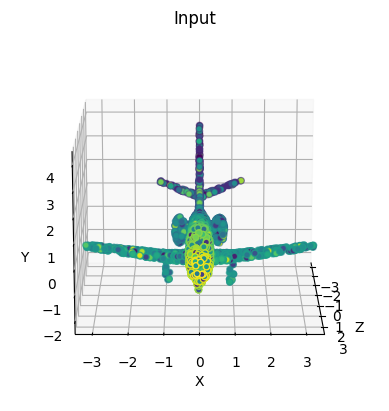

In [10]:
input_pc = point_set[0, ...].detach().cpu().numpy()
fig = visualize_pointcloud(input_pc, "Input")

In [11]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [12]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Part-Segmentation-Noise'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Loss function
num_part = 4
criterion = nn.CrossEntropyLoss()

# Optimization
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Accuracies
train_accuracies = []
val_accuracies = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [13]:
# Actual Training Loop

for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    total_train_acc = 0
    total_val_acc = 0

    # Train
    model.train()
    for (point_set, _, seg) in train_dataloader:
        point_set = point_set.to("cuda").transpose(1,2)
        
        # Add random noise ot the Point Set
        point_set = add_random_noise(point_set)

        optimizer.zero_grad()

        output = model(point_set).transpose(1,2)
        output = output.reshape(-1, num_part)

        seg = seg.to("cuda").long()
        seg = seg.flatten()


        loss = criterion(output, seg)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += output.data.max(1)[1].eq(seg).sum() / seg.shape[0]

    # Training epoch done => Step for the LR Scheduler
    lr_scheduler.step()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    epoch_train_acc = total_train_acc / len(train_dataloader)
    train_accuracies.append(epoch_train_acc)

    # Validate
    model.eval()
    with torch.no_grad():
        for (point_set, _, seg) in val_dataloader:
            point_set = point_set.to("cuda").transpose(1,2)
            
            # Add random noise ot the Point Set
            point_set = add_random_noise(point_set)

            output = model(point_set).transpose(1,2)
            output = output.reshape(-1, num_part)

            seg = seg.to("cuda").long()
            seg = seg.flatten()

            val_loss = criterion(output, seg)
            total_val_loss += val_loss.item()
            total_val_acc += output.data.max(1)[1].eq(seg).sum() / seg.shape[0]

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    epoch_val_acc = total_val_acc / len(val_dataloader)
    val_accuracies.append(epoch_val_acc)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    writer.add_scalar('Acc/train', epoch_train_acc * 100, epoch)
    writer.add_scalar('Acc/val', epoch_val_acc * 100, epoch)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {epoch_train_acc * 100:.4f}%, Val Acc: {epoch_val_acc * 100:.4f}%")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-part-segmentation-noise/PVCNN-Part-Segmentation-Noise-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)

writer.close()

Epoch 1 | Train Loss: 0.9644, Val Loss: 0.8462, Train Acc: 79.8347%, Val Acc: 90.5053%
Epoch 2 | Train Loss: 0.8519, Val Loss: 0.8357, Train Acc: 89.6745%, Val Acc: 90.9762%
Epoch 3 | Train Loss: 0.8379, Val Loss: 0.8251, Train Acc: 90.7219%, Val Acc: 91.8751%
Epoch 4 | Train Loss: 0.8324, Val Loss: 0.8187, Train Acc: 91.1809%, Val Acc: 92.4702%
Epoch 5 | Train Loss: 0.8292, Val Loss: 0.8160, Train Acc: 91.4546%, Val Acc: 92.7305%
Epoch 6 | Train Loss: 0.8259, Val Loss: 0.8120, Train Acc: 91.7480%, Val Acc: 93.1313%
Epoch 7 | Train Loss: 0.8235, Val Loss: 0.8101, Train Acc: 91.9806%, Val Acc: 93.2857%
Epoch 8 | Train Loss: 0.8214, Val Loss: 0.8089, Train Acc: 92.1780%, Val Acc: 93.3934%
Epoch 9 | Train Loss: 0.8208, Val Loss: 0.8078, Train Acc: 92.2205%, Val Acc: 93.5087%
Epoch 10 | Train Loss: 0.8184, Val Loss: 0.8076, Train Acc: 92.4680%, Val Acc: 93.5264%
Epoch 11 | Train Loss: 0.8169, Val Loss: 0.8054, Train Acc: 92.6118%, Val Acc: 93.7557%
Epoch 12 | Train Loss: 0.8160, Val Loss: 

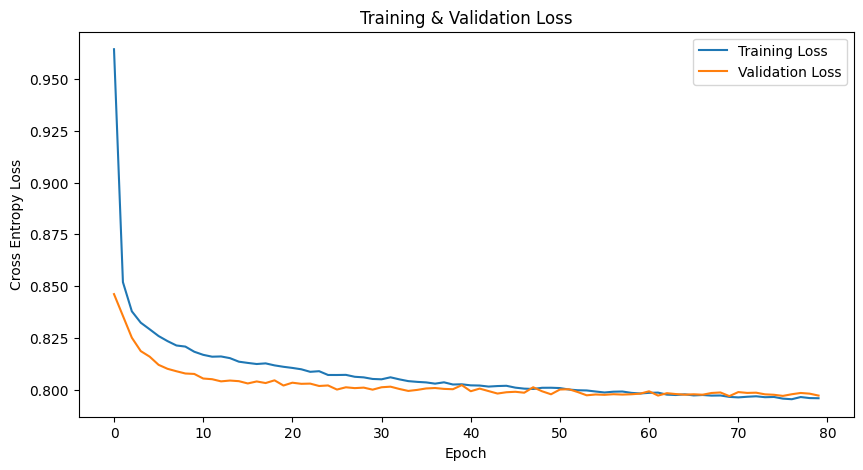

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

In [15]:
for i in range(len(train_accuracies)):
    train_accuracies[i] = train_accuracies[i].cpu()
    val_accuracies[i] = val_accuracies[i].cpu()

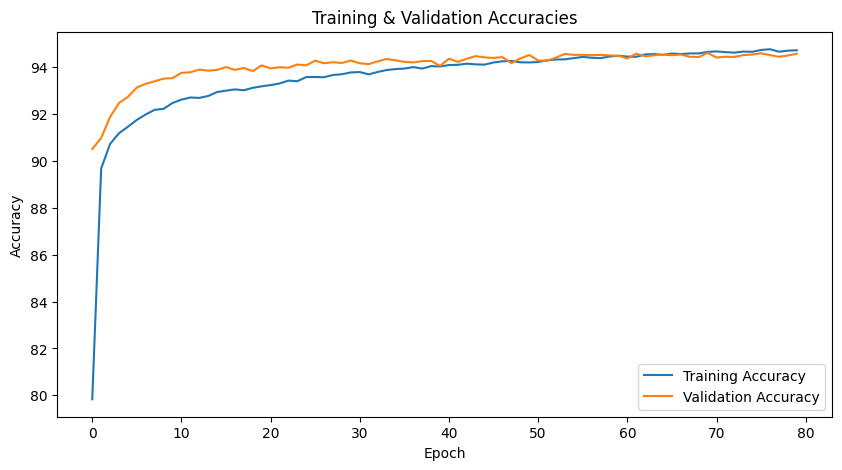

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_accuracies) * 100, label='Training Accuracy')
plt.plot(np.array(val_accuracies) * 100, label='Validation Accuracy')
plt.title('Training & Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
print(f"Best Train Acc: Epoch: {np.argmax(train_accuracies)}, Acc: {np.max(train_accuracies) * 100:.4f}")
print(f"Best Val Acc: Epoch: {np.argmax(val_accuracies)}, Acc: {np.max(val_accuracies) * 100:.4f}")

Best Train Acc: Epoch: 76, Acc: 94.7616
Best Val Acc: Epoch: 69, Acc: 94.6048


In [18]:
print(f"Best Train Loss: Epoch: {np.argmin(training_losses)}, Acc: {np.min(training_losses) * 100:.4f}")
print(f"Best Val Loss: Epoch: {np.argmin(val_losses)}, Acc: {np.min(val_losses) * 100:.4f}")

Best Train Loss: Epoch: 76, Acc: 79.5432
Best Val Loss: Epoch: 69, Acc: 79.6930


In [28]:
model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load(f"output-models/pvcnn-part-segmentation-noise/PVCNN-Part-Segmentation-Noise-e{np.argmax(val_losses)+1}.pth"))

# model.load_state_dict(torch.load("output-models/pvcnn-part-segmentation-noise/PVCNN-Part-Segmentation-Noise-e69.pth"))

<All keys matched successfully>

In [29]:
model.eval()

total_test_loss = 0
total_test_acc = 0
i = 1

with torch.no_grad():  
     for (point_set, _, seg) in test_dataloader:
        point_set = point_set.to("cuda").transpose(1,2)

        # Adding random noise to the test data
        point_set = add_random_noise(point_set)
        
        output = model(point_set).transpose(1,2)
        output = output.reshape(-1, num_part)

        seg = seg.to("cuda").long()
        seg = seg.flatten()

        test_loss = criterion(output, seg)

        total_test_loss += test_loss.item()
        batch_acc = output.data.max(1)[1].eq(seg).sum() / seg.shape[0]
        total_test_acc += batch_acc

        print(f"Batch {i}, CE Loss: {test_loss.item():.4f}, Accuracy: {batch_acc * 100:.4f}%")
        i+=1

avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_acc = total_test_acc / len(test_dataloader)
print(f"Test CE Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc * 100:.4f}%")

Batch 1, CE Loss: 0.8976, Accuracy: 85.0039%
Batch 2, CE Loss: 0.8909, Accuracy: 85.6309%
Batch 3, CE Loss: 0.8961, Accuracy: 85.1250%
Batch 4, CE Loss: 0.8776, Accuracy: 87.3086%
Batch 5, CE Loss: 0.8774, Accuracy: 87.1406%
Batch 6, CE Loss: 0.8634, Accuracy: 88.7344%
Test CE Loss: 0.8838, Test Accuracy: 86.4906%


In [30]:
with torch.no_grad():  
     for (point_set, _, seg) in test_dataloader:
        point_set = point_set.to("cuda").transpose(1,2)
        
        # Adding random noise to the test data
        point_set = add_random_noise(point_set)
        
        output = model(point_set).transpose(1,2)
        break

In [31]:
output_parts = output.data.max(2)[1]
output_parts.shape

torch.Size([50, 2048])

In [32]:
output_pc = point_set.transpose(1,2)
output_pc.shape

torch.Size([50, 2048, 3])

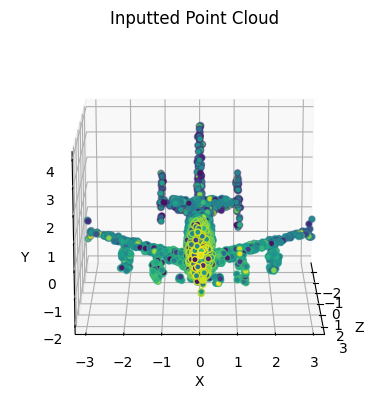

In [35]:
input_np = output_pc[20,...].squeeze().detach().cpu().numpy()
fig = visualize_pointcloud(input_np, f"Inputted Point Cloud")

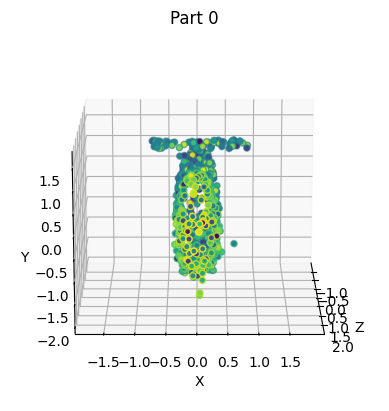

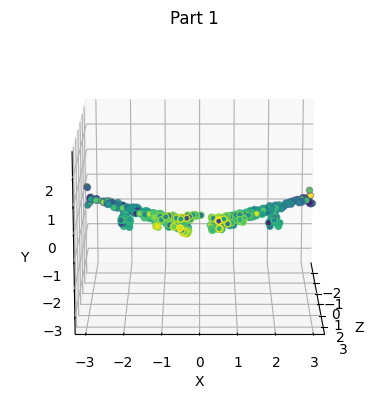

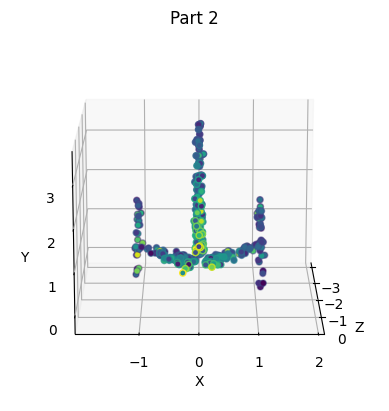

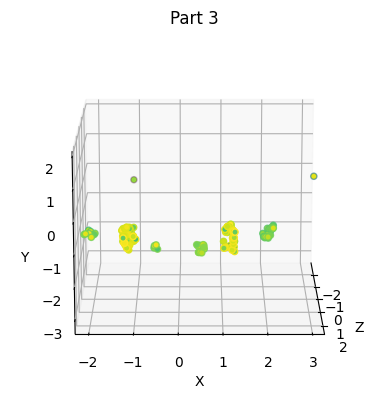

In [37]:
output_sample_parts = output_parts[20, ...].detach().cpu().numpy()
for i in range(4):
    pc_part = input_np[output_sample_parts == i]
    fig = visualize_pointcloud(pc_part, f"Part {i}")

In [39]:
output_sample_parts = output_parts[0, ...].detach().cpu().numpy()
for i in range(4):
    pc_part = input_np[output_sample_parts == i]
    print(pc_part.shape)

print("--------")

output_sample_parts = output_parts[1, ...].detach().cpu().numpy()
for i in range(4):
    pc_part = input_np[output_sample_parts == i]
    print(pc_part.shape)

(910, 3)
(991, 3)
(147, 3)
(0, 3)
--------
(1003, 3)
(502, 3)
(314, 3)
(229, 3)


In [40]:
# Let's figure out how we can create patches based on the part segmentation

pc_set = point_set.transpose(1,2)

pc_set.shape, output_parts.shape

(torch.Size([50, 2048, 3]), torch.Size([50, 2048]))

In [41]:
pc_set[output_parts == 1, :].shape

torch.Size([32856, 3])

In [42]:
(output_parts == 1).shape

torch.Size([50, 2048])

In [43]:
# The problem is that each patch has different shapes... Which makes it hard to feed one big
# tensor into the PVCNN since it is flattened and we can't differentiate the patches.

# We go sequentially:
for (input, part_seg) in zip(pc_set, output_parts):
    print(input.shape, part_seg.shape)

    for i in range(num_part):
        # We will feed the patches like that to the refinement PVCNN network.
        print(input[part_seg == i,...].shape)

    break

torch.Size([2048, 3]) torch.Size([2048])
torch.Size([910, 3])
torch.Size([991, 3])
torch.Size([147, 3])
torch.Size([0, 3])


In [44]:
# Let's apply part segmentation on the PVD output

from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Total number of data:400
Min number of points: (train)2048 (test)2048


In [51]:
model.eval()
i = 0
with torch.no_grad():
    for batch in dataloader_pvd:
        input = batch["test_points"]
        output_pvd_seg = model(input.to("cuda").transpose(1,2))
        if i > 1:
            break
        i+=1

In [52]:
output_pvd_seg = output_pvd_seg.transpose(1,2)
output_pvd_seg.shape

torch.Size([20, 2048, 4])

In [53]:
output_parts = output_pvd_seg.data.max(2)[1]
input_pc = input.detach().cpu().numpy()
input_pc.shape, output_parts.min(), output_parts.max()

((20, 2048, 3), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'))

In [57]:
INDEX = 0

In [58]:
output_sample_parts = output_parts[INDEX, ...].detach().cpu().numpy()
output_sample_parts.shape, output_sample_parts.min(), output_sample_parts.max()

((2048,), 0, 3)

(806, 3)
(807, 3)
(429, 3)
(6, 3)


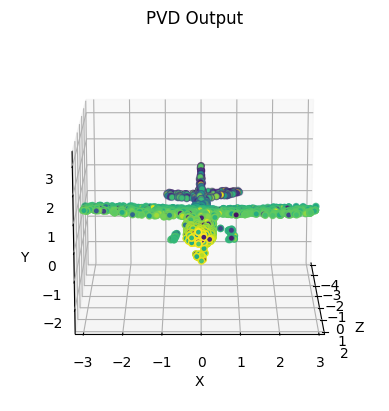

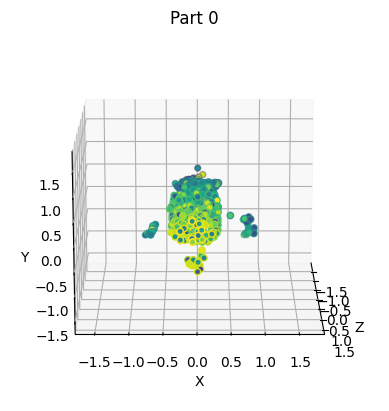

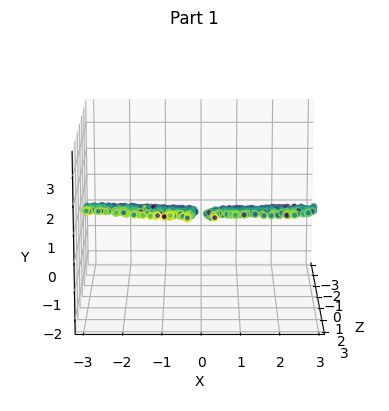

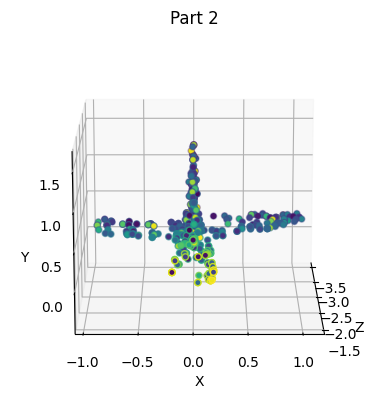

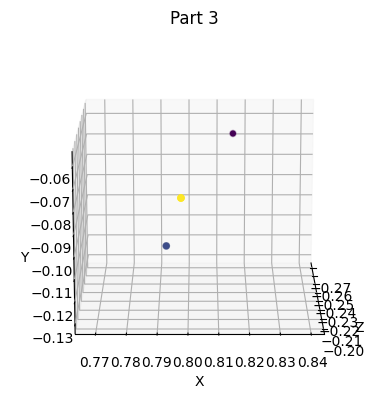

In [59]:
fig = visualize_pointcloud(input_pc[INDEX, ...], "PVD Output")

for i in range(output_sample_parts.max() + 1):
    input_pc_part = input_pc[INDEX, output_sample_parts == i, :]
    print(input_pc_part.shape)
    fig = visualize_pointcloud(input_pc_part, f"Part {i}")

In [60]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)


Total number of data:2832
Min number of points: (train)2048 (test)2048


In [71]:
model.eval()
i = 0
with torch.no_grad():
    for batch in train_dataloader:
        input = batch["test_points"].to("cuda").transpose(1,2)
        input = add_random_noise(input)

        output_shapenet_seg = model(input)
        if i > 1:
            break
        i+=1

In [72]:
output_shapenet_seg = output_shapenet_seg.transpose(1,2)
output_shapenet_seg.shape

torch.Size([20, 2048, 4])

In [74]:
output_parts = output_shapenet_seg.data.max(2)[1]
input_pc = input.transpose(1,2).detach().cpu().numpy()
input_pc.shape, output_parts.min(), output_parts.max()

((20, 2048, 3), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'))

In [75]:
INDEX = 5

In [76]:
output_sample_parts = output_parts[INDEX, ...].detach().cpu().numpy()
output_sample_parts.shape, output_sample_parts.min(), output_sample_parts.max()

((2048,), 0, 3)

(883, 3)
(660, 3)
(333, 3)
(172, 3)


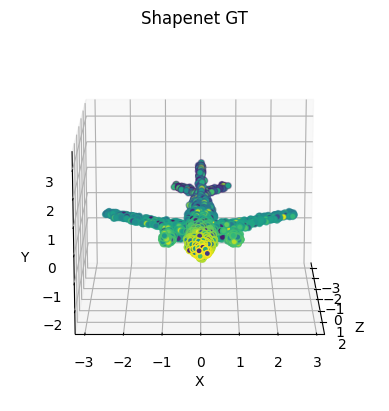

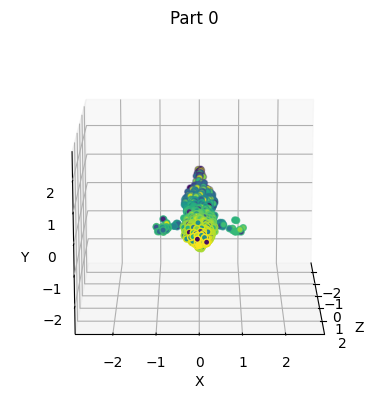

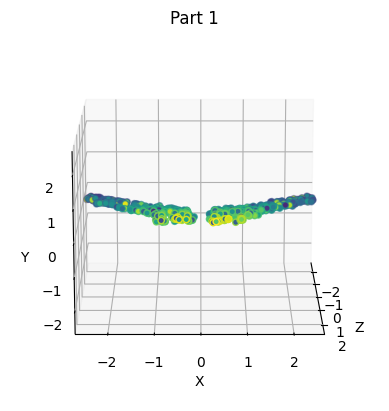

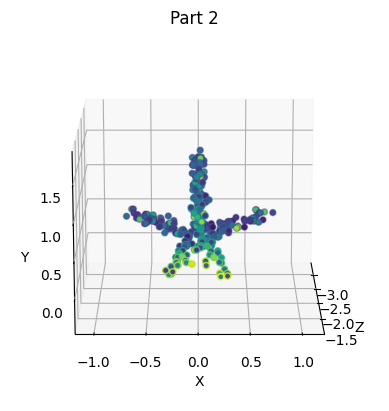

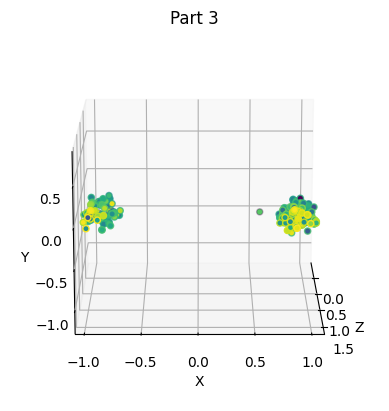

In [78]:
fig = visualize_pointcloud(input_pc[INDEX, ...], "Shapenet GT")

for i in range(output_sample_parts.max() + 1):
    input_pc_part = input_pc[INDEX, output_sample_parts == i, :]
    print(input_pc_part.shape)
    fig = visualize_pointcloud(input_pc_part, f"Part {i}")